# Kevitsa DC Forward Similation

In [1]:
import cPickle as pickle
from SimPEG import EM, Mesh, Utils, Maps
from SimPEG.Survey import Data
%pylab inline
import numpy as np
from pymatsolver import PardisoSolver
from matplotlib.colors import LogNorm
from ipywidgets import interact, IntSlider

Populating the interactive namespace from numpy and matplotlib


## Setup

We have stored the data and simulation mesh so that they can just be downloaded and used here

In [2]:
url = "https://storage.googleapis.com/simpeg/kevitsa_synthetic/"
files = ['dcipdata_12150N.txt', 'dc_mesh.txt', 'dc_sigma.txt', 'dc_topo.txt']
keys = ['data', 'mesh', 'sigma', 'topo']
downloads = Utils.download([url + f for f in files], folder='./KevitsaDC', overwrite=True)
downloads = dict(zip(keys, downloads))

overwriting dcipdata_12150N.txt
overwriting dc_mesh.txt
overwriting dc_sigma.txt
overwriting dc_topo.txt
Download completed!


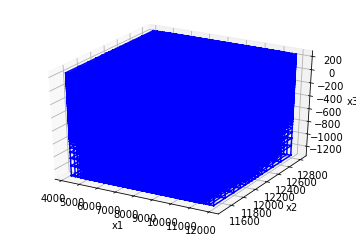

In [3]:
mesh = Mesh.TensorMesh.readUBC(downloads["mesh"])
sigma = mesh.readModelUBC(downloads["sigma"])
topo = np.loadtxt(downloads["topo"])
dcipdata = np.loadtxt(downloads["data"])
actind = ~np.isnan(sigma)
mesh.plotGrid()

## Model

This model is a synthetic based on geologic surfaces interpreted from seismic data over the Kevitsa deposit in Finland. Synthetic 3D conductivity model is generated, and below figure shows conductivity section acrosses the mineralzined zone of interest. Nearsurface conductor on the lefthand side corresponds to sedimentary unit, and embedded conductor on the righthand side indicates conductive mineralized zone. 

/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


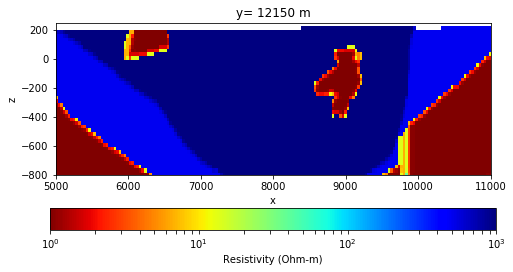

In [4]:
figsize(8, 4)
indy = 6
temp = 1./sigma.copy()
temp[~actind] = np.nan
out = mesh.plotSlice(temp, normal="Y", ind=indy, pcolorOpts={"norm": LogNorm(), "cmap":"jet_r"}, clim=(1e0, 1e3))
plt.ylim(-800, 250)
plt.xlim(5000, 11000)
plt.gca().set_aspect(2.)
plt.title(("y= %d m")%(mesh.vectorCCy[indy]))
cb = plt.colorbar(out[0], orientation="horizontal")
cb.set_label("Resistivity (Ohm-m)")

## Survey

Direct current (DC) resisistivity and IP survey have been perforemd by using Titan24 system; pole-dpole array was used. We use a same survey set up at 12150N line, having 61 current sources (poles). Largest offset between current pole and potential eletrodes are around 2 km. We read in field data using below script, and form a DC survey object that we can pass to our DC problem.

In [5]:
def getGeometricFactor(locA, locB, locsM, locsN, eps = 0.01):    
    """
    Geometric factor for a pole-dipole survey
    """
    MA = np.abs(locA[0] - locsM[:, 0]) 
    MB = np.abs(locB[0] - locsM[:, 0]) 
    NA = np.abs(locA[0] - locsN[:, 0]) 
    NB = np.abs(locB[0] - locsN[:, 0])     
    geometric = 1./(2*np.pi) * (1/MA - 1/NA)
    return geometric

In [6]:

A = dcipdata[:,:2]
B = dcipdata[:,2:4]
M = dcipdata[:,4:6]
N = dcipdata[:,6:8]

Elec_locs = np.vstack((A, B, M, N))
uniqElec = Utils.uniqueRows(Elec_locs)
nElec = len(uniqElec[1])
pts = np.c_[uniqElec[0][:,0],  uniqElec[0][:,1]]
elec_topo = EM.Static.Utils.drapeTopotoLoc(mesh, pts[:,:2], actind=actind)
Elec_locsz = np.ones(Elec_locs.shape[0]) * np.nan

for iElec in range (nElec):
    inds = np.argwhere(uniqElec[2] == iElec)
    Elec_locsz[inds] = elec_topo[iElec,2] 
    
Elec_locs = np.c_[Elec_locs, Elec_locsz]
nloc = int(Elec_locs.shape[0]/4)
A = Elec_locs[:nloc]
B = Elec_locs[nloc:2*nloc]
M = Elec_locs[2*nloc:3*nloc]
N = Elec_locs[3*nloc:4*nloc]

uniq = Utils.uniqueRows(np.c_[A, B])
nSrc = len(uniq[1])
mid_AB = A[:,0]
mid_MN = (M[:,0] + N[:,0]) * 0.5
mid_z = -abs(mid_AB - mid_MN) * 0.4
mid_x = abs(mid_AB + mid_MN) * 0.5

In [7]:
srcLists = []
appres = []
geometric = []
voltage = []
inds_data = []

for iSrc in range (nSrc):
    inds = uniq[2] == iSrc
    # TODO: y-location should be assigned ...
    locsM = M[inds,:]
    locsN = N[inds,:]        
    inds_data.append(np.arange(len(inds))[inds])
    rx = EM.Static.DC.Rx.Dipole(locsM, locsN)    
    locA = uniq[0][iSrc,:3]
    locB = uniq[0][iSrc,3:]    
    src = EM.Static.DC.Src.Pole([rx], locA)        
#     src = EM.Static.DC.Src.Dipole([rx], locA, locB)    
    geometric.append(getGeometricFactor(locA, locB, locsM, locsN))    
    appres.append(dcipdata[:,8][inds])
    voltage.append(dcipdata[:,9][inds])
    srcLists.append(src)
inds_data = np.hstack(inds_data)
geometric = np.hstack(geometric)
dobs_appres = np.hstack(appres)
dobs_voltage = np.hstack(voltage) * 1e-3
DCsurvey = EM.Static.DC.Survey(srcLists)
DCsurvey.dobs = dobs_voltage

## Problem

This is a physics behind DC resistivity survey.  Here we solve Poisson's equation and compute potential in our discretized domain. Survey information is required to run simulation. 

In [8]:
m0 = np.ones(actind.sum())*np.log(1e-3)
actMap = Maps.InjectActiveCells(mesh, actind, np.log(1e-8))
mapping = Maps.ExpMap(mesh) * actMap
problem = EM.Static.DC.Problem3D_N(mesh, sigmaMap=mapping)
problem.Solver = PardisoSolver
if DCsurvey.ispaired:
    DCsurvey.unpair()
problem.pair(DCsurvey)

## Forward Simulation
Things are set. Now we can run simulaton by passing conductivity model to the DC problem. 

In [9]:
f = problem.fields(np.log(sigma)[actind])
dpred = DCsurvey.dpred(np.log(sigma)[actind], f=f)
appres = dpred / geometric
dcdata = Data(DCsurvey, v=dpred)
appresdata = Data(DCsurvey, v=appres)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


### Plot the Data

We are going to plot simulated data for each current pole. By moving slider bar below, you can explore the data at different current pole location. We provide both voltage and apparent resistivity. 

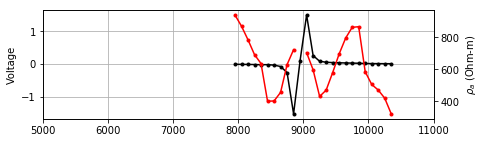

<function __main__.vizdata>

In [10]:
def vizdata(isrc):
    fig = plt.figure(figsize = (7, 2))
    src = srcLists[isrc]
    rx = src.rxList[0]    
    data_temp = dcdata[src, rx]
    appres_temp = appresdata[src, rx]
    midx = (rx.locs[0][:,0] + rx.locs[1][:,0]) * 0.5
    midz = (rx.locs[0][:,2] + rx.locs[1][:,2]) * 0.5
    ax = plt.subplot(111)
    ax_1 = ax.twinx()
    ax.plot(midx, data_temp, 'k.-')
    ax_1.plot(midx, appres_temp, 'r.-')
    ax.set_xlim(5000, 11000)
    ax.set_ylabel("Voltage")
    ax_1.set_ylabel("$\\rho_a$ (Ohm-m)")
    ax.grid(True)
    plt.show()
interact(vizdata, isrc=(0, DCsurvey.nSrc-1, 1))

### Plot the currents

Did you understand simluated data? why they are changing? Here we show how currents flow in the earth medium. Similarly, you can move slider bar to see how current changes depending upon current source location. 

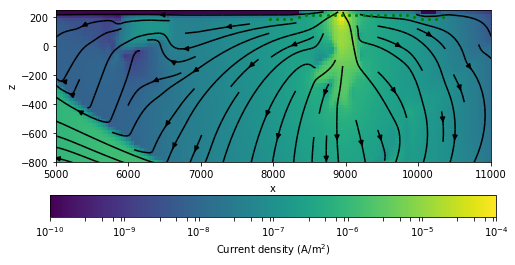

<function __main__.vizJ>

In [11]:
fig = plt.figure(figsize = (7, 1.5))
def vizJ(isrc):
    indy = 6
    src = srcLists[isrc]
    rx = src.rxList[0]
    out = mesh.plotSlice(f[src, 'j'], vType="E", normal="Y", view="vec", ind=indy, streamOpts={"color":"k"}, pcolorOpts={"norm": LogNorm(), "cmap":"viridis"}, clim=(1e-10, 1e-4))
    plt.plot(src.loc[0], src.loc[1], 'ro')
    plt.ylim(-800, 250)
    plt.xlim(5000, 11000)
    plt.gca().set_aspect(2.)
    # plt.title(("y= %d m")%(mesh.vectorCCy[indy]))
    plt.title("")
    cb = plt.colorbar(out[0], orientation="horizontal")
    cb.set_label("Current density (A/m$^2$)")
    midx = (rx.locs[0][:,0] + rx.locs[1][:,0]) * 0.5
    midz = (rx.locs[0][:,2] + rx.locs[1][:,2]) * 0.5
    plt.plot(midx, midz, 'g.', ms=4)
    plt.gca().get_xlim()
    plt.show()
interact(vizJ, isrc=(0, DCsurvey.nSrc-1, 1))

### Plot Pseudo section

We are going to plot simulated data for each current pole. By moving slider bar below, you can explore the data at different current pole location. 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app


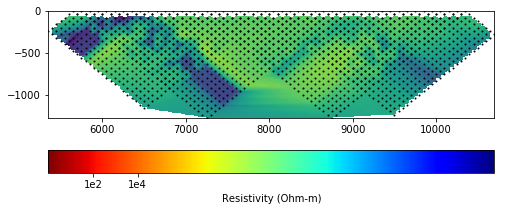

In [12]:
vmin, vmax = 1, 1e4
appres = dpred/geometric
temp = appres.copy()
Utils.plot2Ddata(np.c_[mid_x[inds_data], mid_z[inds_data]], temp, ncontour=100, dataloc=True, scale="log", contourOpts={"vmin":np.log10(vmin), "vmax":np.log10(vmax)})
cb = plt.colorbar(out[0], orientation="horizontal", format="1e%.0f", ticks=np.linspace(np.log10(vmin), np.log10(vmax), 3))
cb.set_label("Resistivity (Ohm-m)")
# plt.title("Line 12150N")

### Plot Field data (pseudo-section)

Let's see how the field data looks like on this line (12150N). Are they similar with our simulated data? 

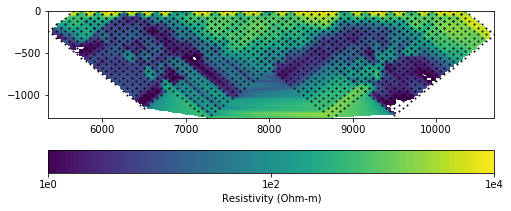

In [13]:
vmin, vmax = 1, 1e4
temp = dcipdata[:,8].copy()
temp[dcipdata[:,8]<vmin] = vmin
temp[dcipdata[:,8]>vmax] = vmax
out = Utils.plot2Ddata(np.c_[mid_x[inds_data], mid_z[inds_data]], temp[inds_data], ncontour=100, dataloc=True, scale="log")
cb = plt.colorbar(out[0], orientation="horizontal", format="1e%.0f", ticks=np.linspace(np.log10(vmin), np.log10(vmax), 3))
cb.set_label("Resistivity (Ohm-m)")
# plt.title("Line 12150N")